# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaminiakula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Exploratory Data Analysis

In [50]:
#Load the data

data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [51]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [52]:
#Column names
print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [53]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [54]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [55]:
#We will drop the null record

data.dropna(inplace=True)

In [56]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [57]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [58]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [59]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [60]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [61]:
len(data)

3149

In [62]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

#almost 70% of the reviews are 5 star 

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

In [63]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

# we are considering ratings 3,4,5 as positive anf 1,2 as negative , so these are two groups, we are not taking 3 as nutral
#bec 3 is very less and it will cause class imbalance.

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


Let's plot the above values in a pie chart

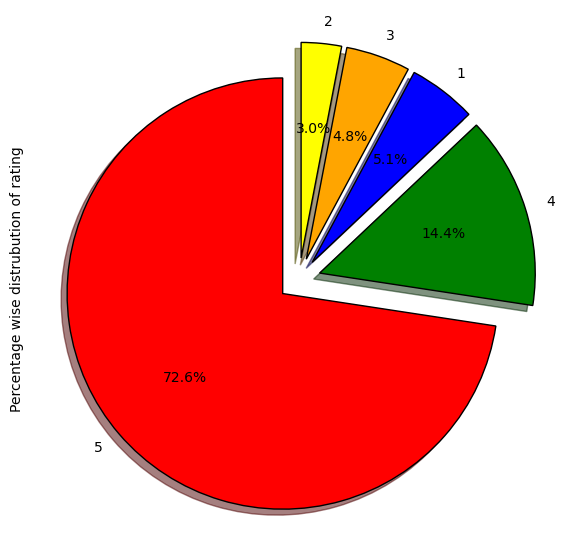

In [64]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [65]:
#Distinct values of 'feedback' and its count 
#original intution was that feeback=1 means that feedback was given and 0 means feeback wasnt given
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [66]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [67]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

In [68]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

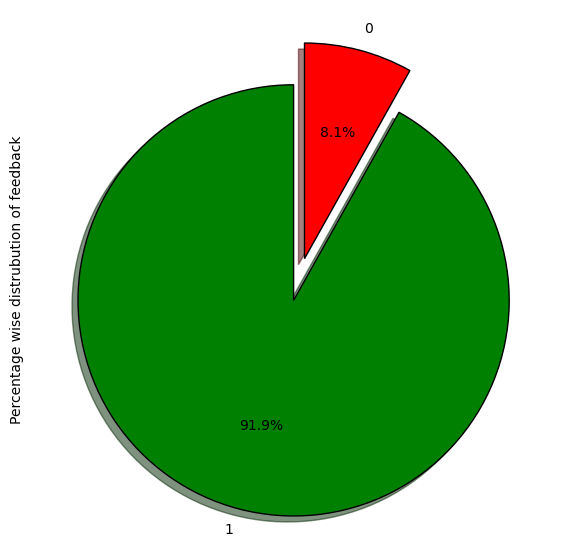

In [69]:
fig = plt.figure(figsize=(7,7))

colors = ('green', 'red')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [70]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


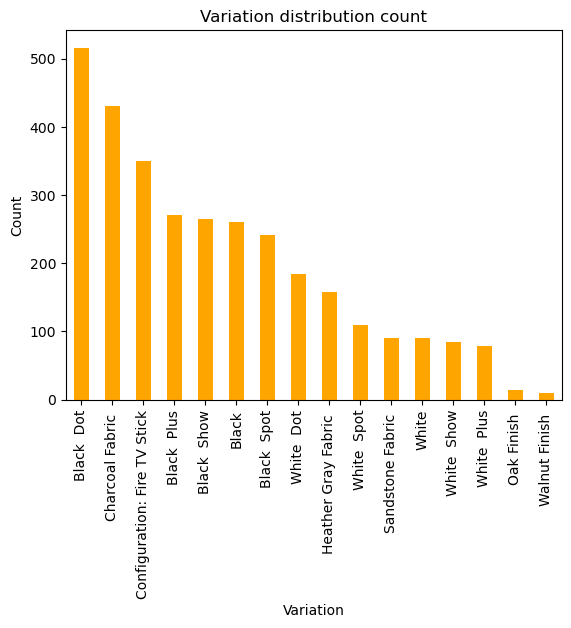

In [71]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

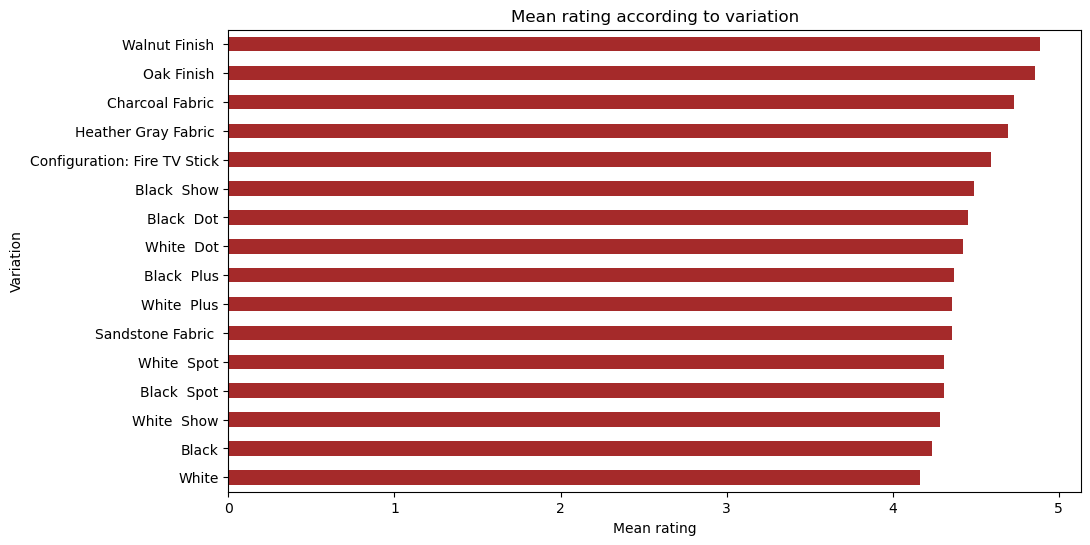

In [72]:
#pltting the mean ratings vs the variation and sorting it in decending order
data.groupby('variation')['rating'].mean().sort_values().plot.barh(color='brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Mean rating')
plt.ylabel('Variation')
plt.show()


Length analysis for full dataset

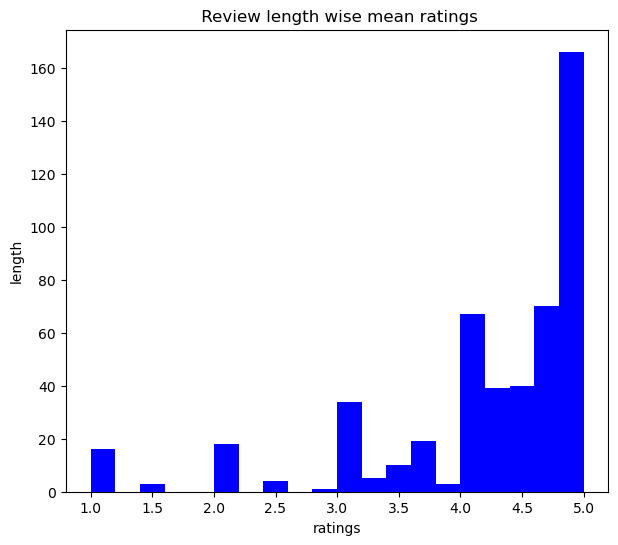

In [73]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [74]:
#we are taking the english stopwords and storing them in cv variable  and then fitting it into our dataset
# this step filters all the stop words from the reviews column
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)


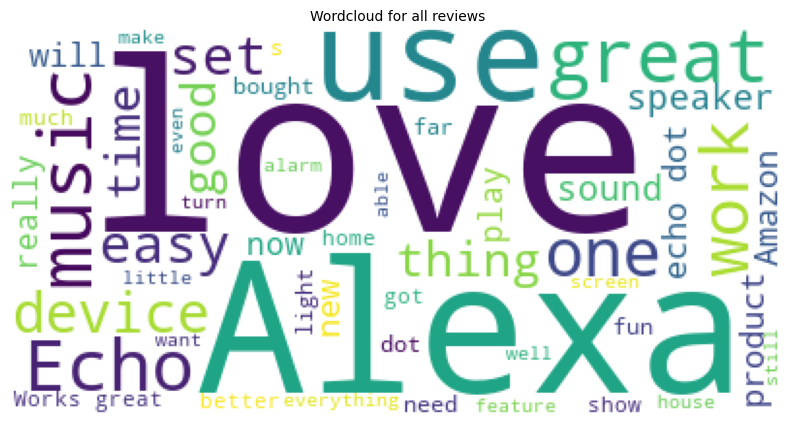

In [75]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [76]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


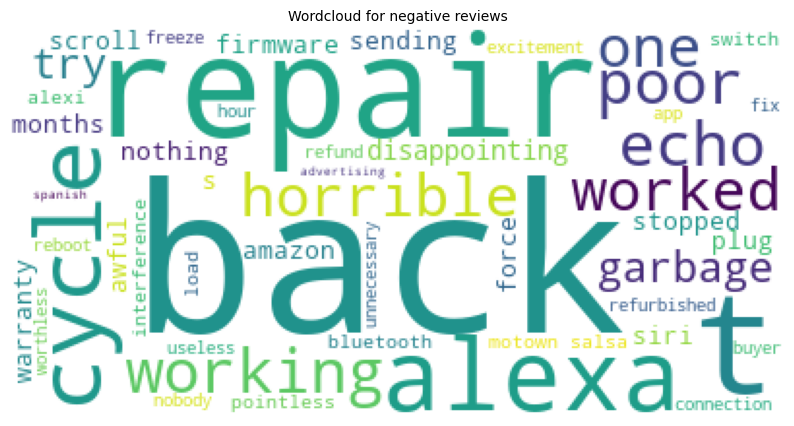

In [77]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

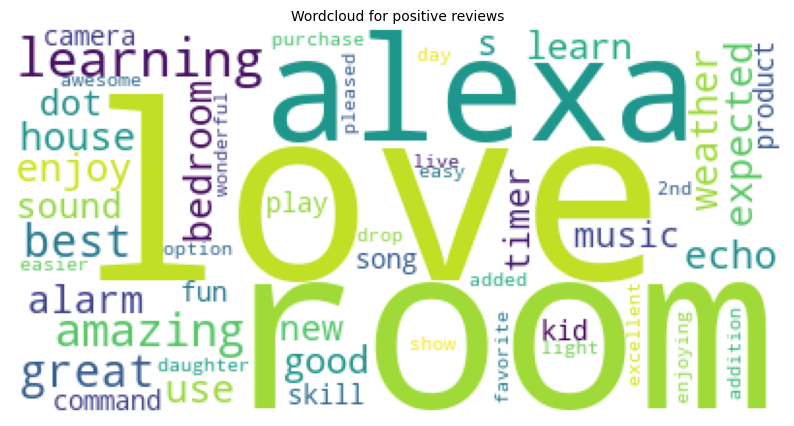

In [78]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [79]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [80]:
#vectorization process: where each of the sentences in corpus(paragraphs) are converted into 0's and 1's its
#prebuit in sklearn library.
#we are using bag of words to do the vectorization
cv = CountVectorizer(max_features = 2500) #here we are considering to take the top 2500 features
#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values


In [82]:
import os
os.makedirs('Models', exist_ok=True)
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [83]:
print(f"X shape: {X.shape}") #here the rows of x are the noof sentences in the reviews and columns 
#are noof features(top 2500 words) which we got during vectorization using bag of words 

print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [85]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")
print(X_train[:5])  # Print the first 5 rows of the array


X train max value: 12
X test max value: 10
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [86]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

#### Random Forest

In [87]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [88]:
#Predicting on the test set
y_preds_rf = model_rf.predict(X_test)

In [89]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_rf)

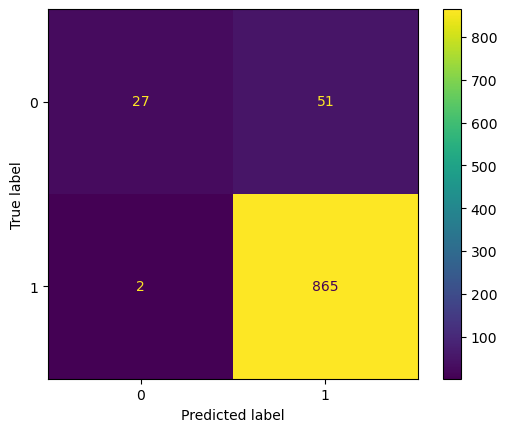

In [90]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

Training Accuracy RF : 0.9945553539019963
Accuracy for random forest: 0.9439153439153439


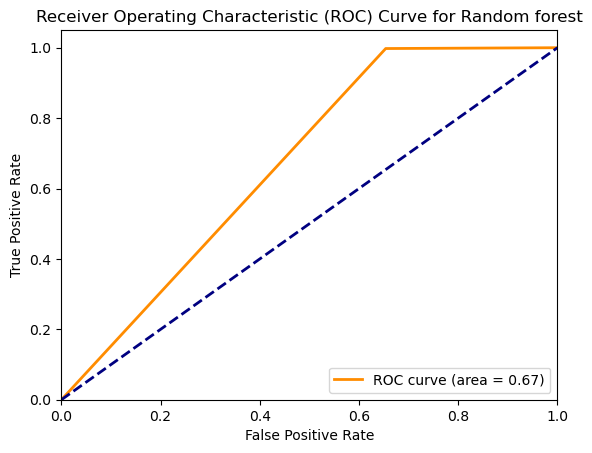

In [91]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt


# Calculate accuracy
print("Training Accuracy RF :", model_rf.score(X_train, y_train))
accuracy_rf = accuracy_score(y_test, y_preds_rf)
train_accuracy_rf=model_rf.score(X_train, y_train)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds_rf)
roc_auc = auc(fpr, tpr)

print("Accuracy for random forest:", accuracy_rf)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random forest')
plt.legend(loc="lower right")
plt.show()




#### XgBoost

In [92]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
y_preds_xgb = model_xgb.predict(X_test)

In [94]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_xgb)
print(cm)

[[ 30  48]
 [  7 860]]


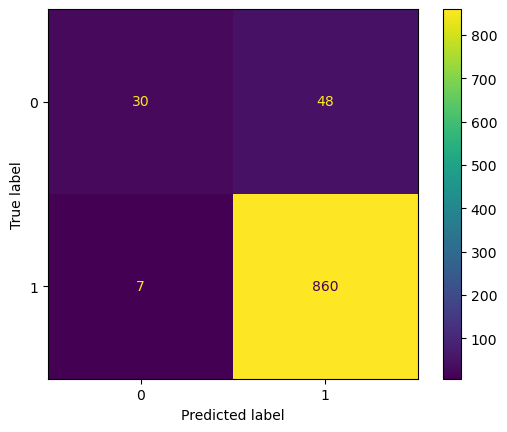

In [95]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

Training Accuracy_xgb : 0.971415607985481
Accuracy for XGBoost: 0.9417989417989417


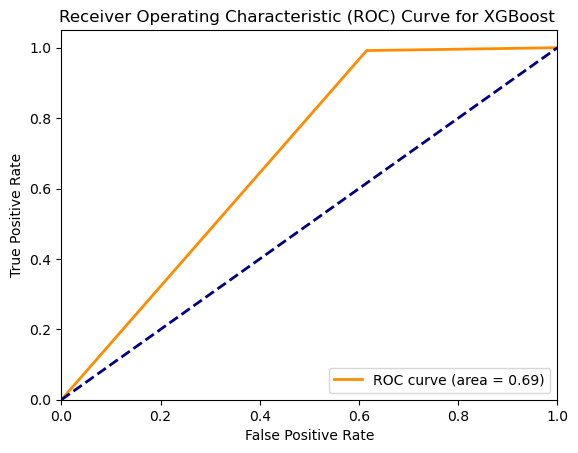

In [96]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy
print("Training Accuracy_xgb :", model_xgb.score(X_train, y_train))
accuracy_xgb = accuracy_score(y_test, y_preds_xgb)
train_accuracy_xgb=model_xgb.score(X_train, y_train)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds_xgb)
roc_auc = auc(fpr, tpr)

print("Accuracy for XGBoost:", accuracy_xgb)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost ')
plt.legend(loc="lower right")
plt.show()

In [98]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [99]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
model_dt

DecisionTreeClassifier()

In [100]:
y_preds_dt = model_dt.predict(X_test)

In [34]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_dt)
print(cm)

[[ 43  35]
 [ 39 828]]


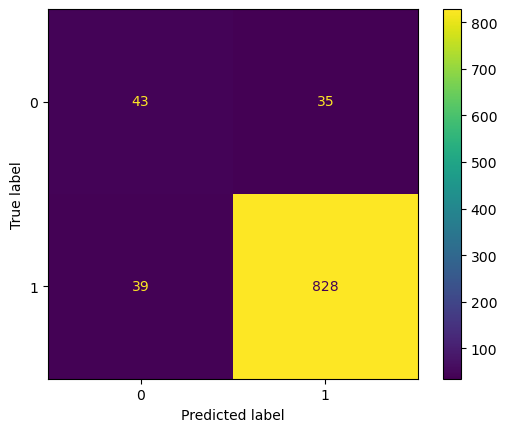

In [35]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

Training Accuracy _dt: 0.9945553539019963
Accuracy for decision tree: 0.9216931216931217


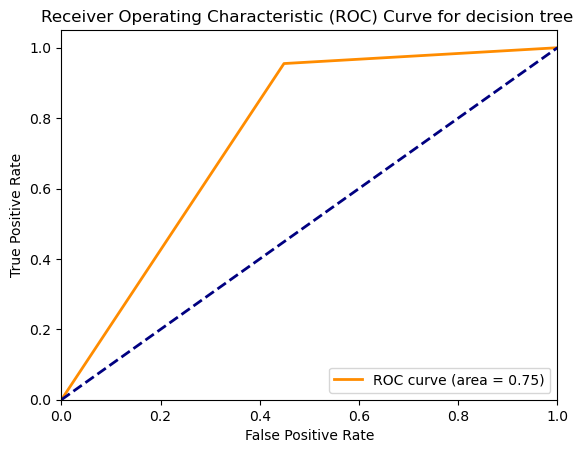

In [45]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy
print("Training Accuracy _dt:", model_dt.score(X_train, y_train))
accuracy_dt = accuracy_score(y_test, y_preds_dt)
train_accuracy_dt=model_dt.score(X_train, y_train)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds_dt)
roc_auc = auc(fpr, tpr)

print("Accuracy for decision tree:", accuracy_dt)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for decision tree ')
plt.legend(loc="lower right")
plt.show()

# Performace comparision for all the models

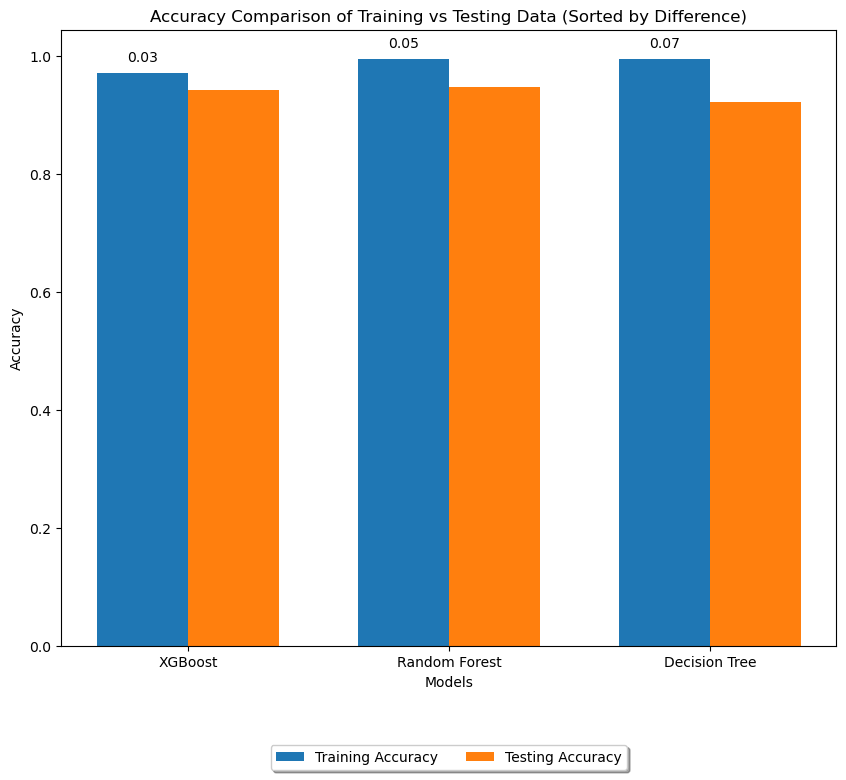

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define models and their respective accuracy scores
models = ['Random Forest', 'XGBoost', 'Decision Tree']
train_accuracy = [train_accuracy_rf, train_accuracy_xgb, train_accuracy_dt]
test_accuracy = [accuracy_rf, accuracy_xgb, accuracy_dt]

# Calculate absolute differences between training and testing accuracies
diff_accuracies = [abs(train - test) for train, test in zip(train_accuracy, test_accuracy)]

# Sort models based on absolute differences
sorted_indices = np.argsort(diff_accuracies)
sorted_models = [models[i] for i in sorted_indices]
sorted_train_accuracy = [train_accuracy[i] for i in sorted_indices]
sorted_test_accuracy = [test_accuracy[i] for i in sorted_indices]

# Define the x-axis positions for the bars
x = np.arange(len(models))

# Define bar width
width = 0.35

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Plot bars for training accuracy
train_bars = plt.bar(x - width/2, sorted_train_accuracy, width, label='Training Accuracy')

# Plot bars for testing accuracy
test_bars = plt.bar(x + width/2, sorted_test_accuracy, width, label='Testing Accuracy')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Training vs Testing Data (Sorted by Difference)')
plt.xticks(x, sorted_models)

# Add annotations for the difference in accuracies
for train_bar, test_bar in zip(train_bars, test_bars):
    height = max(train_bar.get_height(), test_bar.get_height())
    diff = abs(train_bar.get_height() - test_bar.get_height())
    plt.text(train_bar.get_x() + train_bar.get_width()/2, height + 0.02, f'{diff:.2f}', ha='center')

# Plot legend at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# Show plot
plt.show()


Training Accuracy Decision Tree: 0.9945553539019963
Training Accuracy XGBoost: 0.971415607985481
Training Accuracy Random Forest: 0.9945553539019963


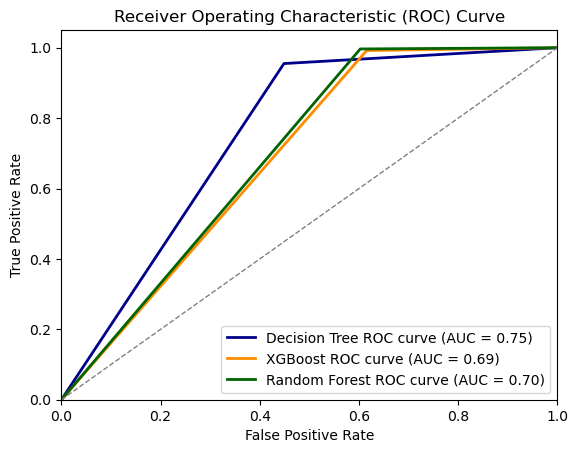

In [47]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy for decision tree
print("Training Accuracy Decision Tree:", model_dt.score(X_train, y_train))
accuracy_dt = accuracy_score(y_test, y_preds_dt)
train_accuracy_dt = model_dt.score(X_train, y_train)

# Calculate ROC curve and AUC for decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_preds_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Calculate accuracy for XGBoost
print("Training Accuracy XGBoost:", model_xgb.score(X_train, y_train))
accuracy_xgb = accuracy_score(y_test, y_preds_xgb)
train_accuracy_xgb = model_xgb.score(X_train, y_train)

# Calculate ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate accuracy for random forest
print("Training Accuracy Random Forest:", model_rf.score(X_train, y_train))
accuracy_rf = accuracy_score(y_test, y_preds_rf)
train_accuracy_rf = model_rf.score(X_train, y_train)

# Calculate ROC curve and AUC for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves for all models
plt.figure()

# Plot ROC curve for decision tree
plt.plot(fpr_dt, tpr_dt, color='darkblue', lw=2, label='Decision Tree ROC curve (AUC = %0.2f)' % roc_auc_dt)

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='XGBoost ROC curve (AUC = %0.2f)' % roc_auc_xgb)

# Plot ROC curve for random forest
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label='Random Forest ROC curve (AUC = %0.2f)' % roc_auc_rf)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## analysis and conclusion of the models

The above bar graphs show the accuracy plots of each of models on training and testing data, the differene of these accuracies are shown as well.From the plot we can see that although the accuracy of the decision tree is highest for the traiining data the accuracy on the testing data is low as compared to other models, which leads to over fitting. Same is the case for Random forest model.
Therefore, we can conclude that the best model to implemnet for analysis of the Alexa reviews is the XGBoost model which has decent accuracy of 97% on the training data and 95% accuracy on the testing data.

# I have further used pickle libary to store our existing model and using vscode and tried to test the model using streamlit in such a way that it takes input and prints on the screens if the review is negative or not



streamlit run app_streamlit.py  and the url is Local URL: http://localhost:8501
  Network URL: http://10.0.0.63:8501
  